# Algorithmic Fairness, Accountability, and Ethics, Spring 2025

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [5]:
# Importing libraries 
# TODO check that we use them all and delete the ones we don't

# the basic ones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data import
from folktables.acs import adult_filter
from folktables import ACSDataSource

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# performance
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve

from scipy.interpolate import interp1d

In [6]:

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100] # total person's income
    df = df[df['WKHP'] > 0]  ## TODO check what work hours could make sense
    df = df[df['PWGTP'] >= 1] ## This is a person's weight????
    df = df[df["SCHL"]>=15] # added school from 15 years, so account for adults
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

Starting from the template, train two different classifiers on the training data: 
- a white-box model using logistic regression, 
- and a black-box model using a random forest.

Describe the feature engineering and scaling steps you took to train the classifiers (e.g. standardization of features is a good idea for the logistic regression model) and summarize the steps in your report. 

For both models, report on the accuracy of the classifier on the test set.

In [7]:
# logistic regression

logistic_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, penalty="l2", C= 0.8497534359086438, tol=1e-4, solver = "saga"))
logistic_model.fit(X_train, y_train)
log_y_pred = logistic_model.predict(X_test)
log_y_prob = logistic_model.predict_proba(X_test)[:, 1]


In [8]:

log_accuracy = accuracy_score(y_test, log_y_pred)
log_accuracy

0.767983846089127

In [9]:
# Random forest classifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)
forest_y_prob = forest.predict_proba(X_test)[:, 1]

In [10]:

forest_accuracy = accuracy_score(y_test, forest_y_pred)
forest_accuracy

0.7470342429256528

In [11]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


In [12]:
feature_names = X_train.columns

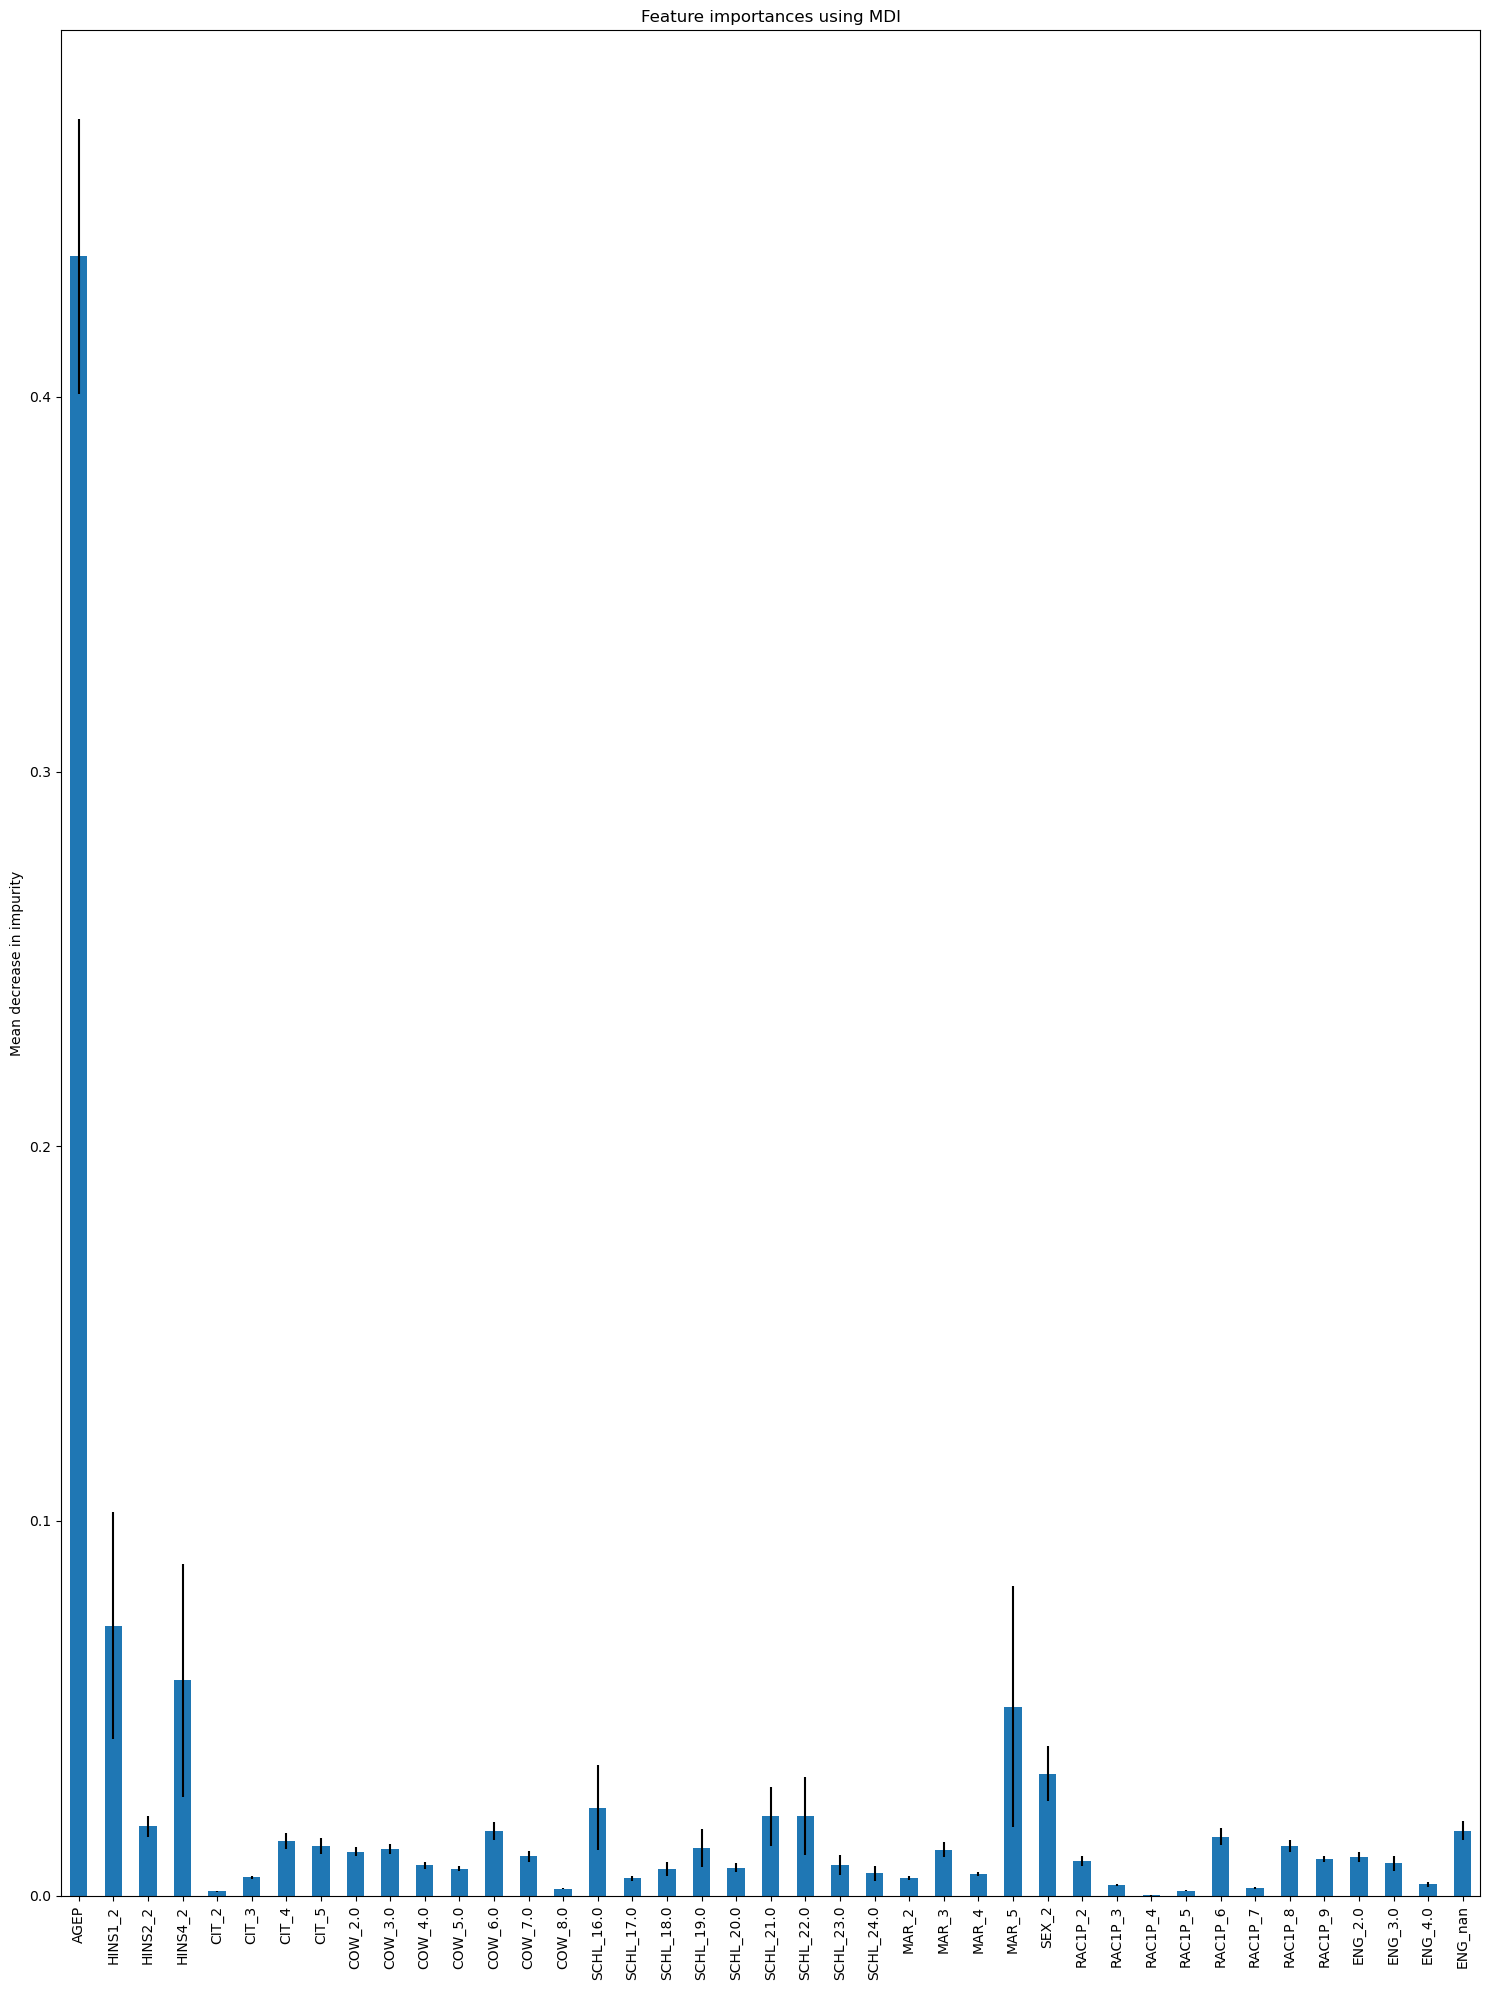

In [13]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Is it Fair?

In [14]:
def stat_parity(pred):
    group1 = np.mean(pred[group_test == 1]) 
    group2 = np.mean(pred[group_test == 2]) 
    return group1, group2

def equal_odds(pred, target):
    group1 = np.mean(pred[(y_test == target) & (group_test == 1)])
    group2 = np.mean(pred[(y_test == target) & (group_test == 2)])
    return group1, group2

def fairness(pred):
    scores = [stat_parity(pred), 
           equal_odds(pred, 0), 
           equal_odds(pred, 1)]
    names = ["stat_parity",
                "eq_odds_t0",
                "eq_odds_t1"]
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        g1,g2 = scores[i]
        new_metrics = {"score":[g1, g2], "metric" : [names[i], names[i]], "group":["male", "female"]}
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)
    
    return df_fair_metrics

log_fairness = fairness(log_y_pred)
forest_fairness = fairness(forest_y_pred)

print(log_fairness)
print()
print(forest_fairness)


      score       metric   group
0  0.686176  stat_parity    male
1  0.568298  stat_parity  female
2  0.352081   eq_odds_t0    male
3  0.319584   eq_odds_t0  female
4  0.873615   eq_odds_t1    male
5  0.798366   eq_odds_t1  female

      score       metric   group
0  0.660543  stat_parity    male
1  0.541444  stat_parity  female
2  0.340018   eq_odds_t0    male
3  0.317890   eq_odds_t0  female
4  0.840369   eq_odds_t1    male
5  0.748238   eq_odds_t1  female


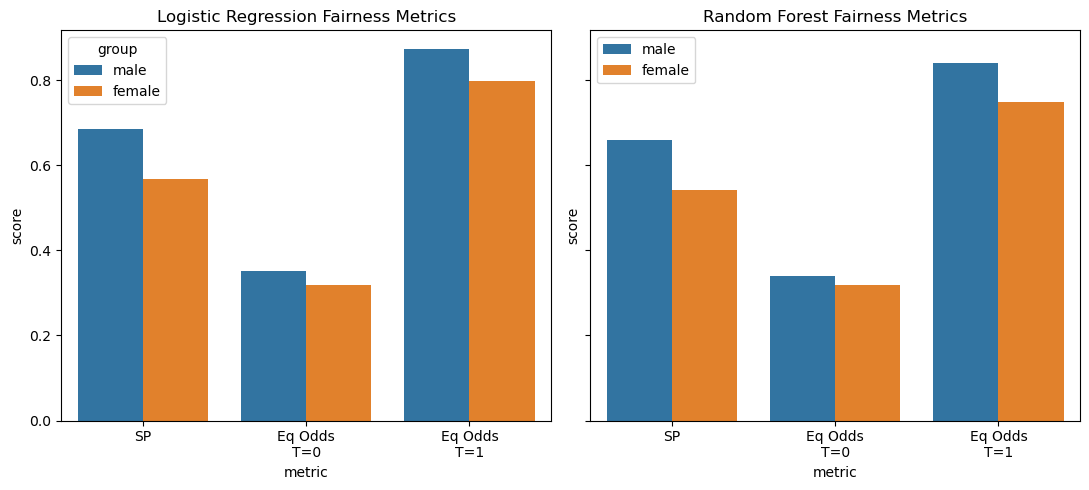

In [15]:
def plot_fairness(log, forest):
    _, ax = plt.subplots(1,2, figsize=(11,5), sharey=True)

    sns.barplot(data = log,
                x = 'metric',
                y = 'score',
                hue = 'group',
                ax=ax[0]
                )

    sns.barplot(data = forest,
                x = 'metric',
                y = 'score',
                hue= 'group',
                ax=ax[1]
                )

    plt.legend()
    ax[0].set_title("Logistic Regression Fairness Metrics")
    ax[1].set_title("Random Forest Fairness Metrics")

    ax[0].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])
    ax[1].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])

    plt.tight_layout()

    plt.show()

plot_fairness(log_fairness, forest_fairness)

## Make it fair

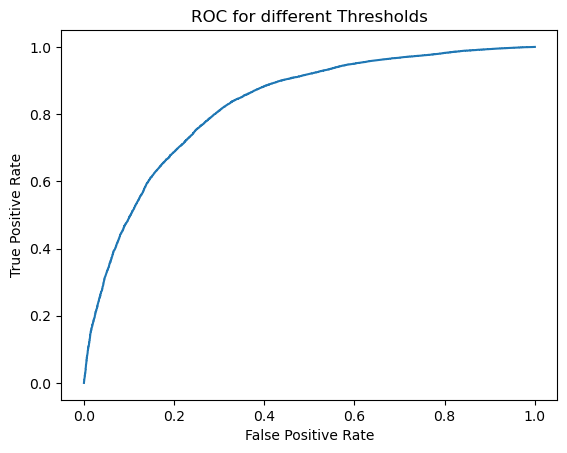

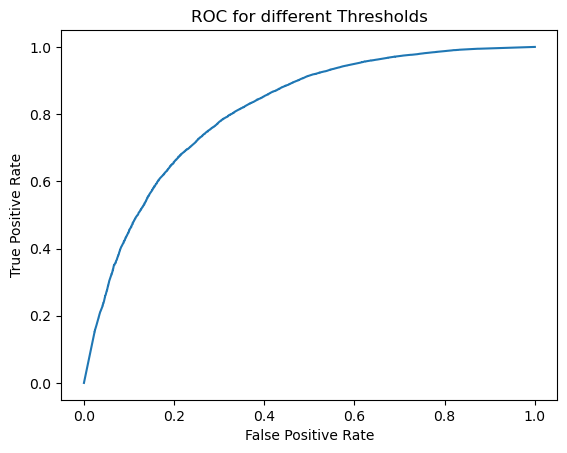

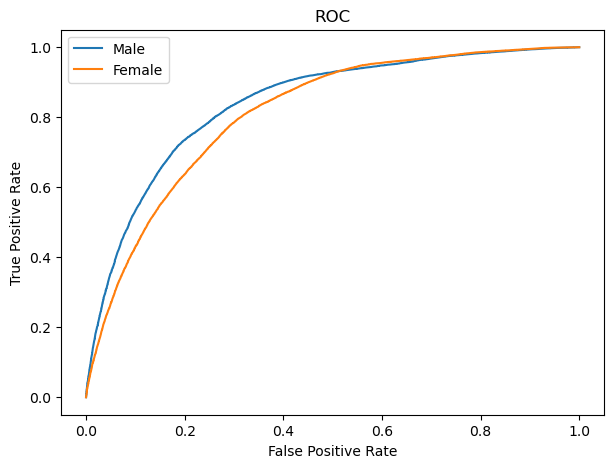

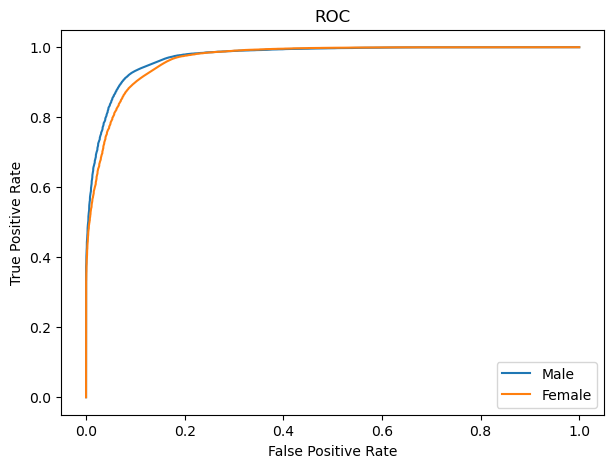

0.986 0.945


In [16]:
def  roc_curve_generator(test, prob): 
    # Compute ROC curve 
    #false positive rate, true positive rate, threshold
    fpr, tpr, thr = roc_curve(test, prob, drop_intermediate=False)

    # Plot it
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set_title("ROC for different Thresholds")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")

def  roc_curve_generator_groups(test_1, prob_1, test_2, prob_2): 
    fpr_1, tpr_1, thr_1 = roc_curve(test_1, prob_1, drop_intermediate=False)
    fpr_2, tpr_2, thr_2 = roc_curve(test_2, prob_2, drop_intermediate=False)

    tpr_diff = []
    fpr_diff = []
    thresholds = []
    for p in np.arange(0.1, 0.99, 0.001):
        tpr_diff.append(abs(tpr_1[tpr_1>p][0] - tpr_2[tpr_2>p][0]))
        fpr_diff.append(abs(fpr_1[tpr_1>p][0] - fpr_2[tpr_2>p][0]))
        thresholds.append((thr_1[tpr_1>p][0], thr_2[tpr_2>p][0]))

    diffs = []
    for i in range(len(fpr_diff)):
        diffs.append(abs(fpr_diff[i] - tpr_diff[i]))

    n = np.argmin(diffs)

    thr_group1, thr_group2 = thresholds[n]


    #plot
    _, ax = plt.subplots(1,1, figsize=(7,5))

    ax.plot(fpr_1, tpr_1, label='Male')
    ax.plot(fpr_2, tpr_2, label='Female')

    ax.set_title("ROC")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    plt.legend()
    plt.show()
    return thr_group1, thr_group2

roc_curve_generator(y_test, log_y_prob)
roc_curve_generator(y_test, forest_y_prob)

# separate ROC for each group
log_y_prob_group1 = logistic_model.predict_proba(X_train[group_train==1])[:,1]
log_y_prob_group2 = logistic_model.predict_proba(X_train[group_train==2])[:,1]
log_thr_group1, log_thr_group2 = roc_curve_generator_groups(y_train[group_train==1], log_y_prob_group1, y_train[group_train==2], log_y_prob_group2)

forest_y_prob_group1 = forest.predict_proba(X_train[group_train==1])[:,1]
forest_y_prob_group2 = forest.predict_proba(X_train[group_train==2])[:,1]
forest_thr_group1, forest_thr_group2 = roc_curve_generator_groups(y_train[group_train==1], forest_y_prob_group1, y_train[group_train==2], forest_y_prob_group2)


print(forest_thr_group1, forest_thr_group2)



0.7443138794626581 0.5376223462433743
      score       metric   group
0  0.779602  stat_parity    male
1  0.732562  stat_parity  female
2  0.506785   eq_odds_t0    male
3  0.521713   eq_odds_t0  female
4  0.932662   eq_odds_t1    male
5  0.927604   eq_odds_t1  female

      score       metric   group
0  0.173576  stat_parity    male
1  0.140316  stat_parity  female
2  0.043275   eq_odds_t0    male
3  0.046692   eq_odds_t0  female
4  0.246680   eq_odds_t1    male
5  0.226922   eq_odds_t1  female


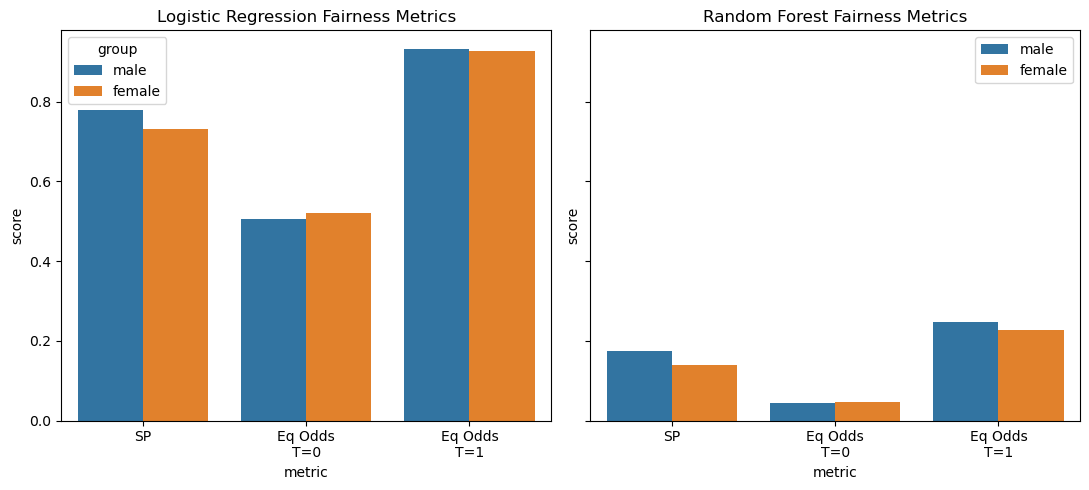

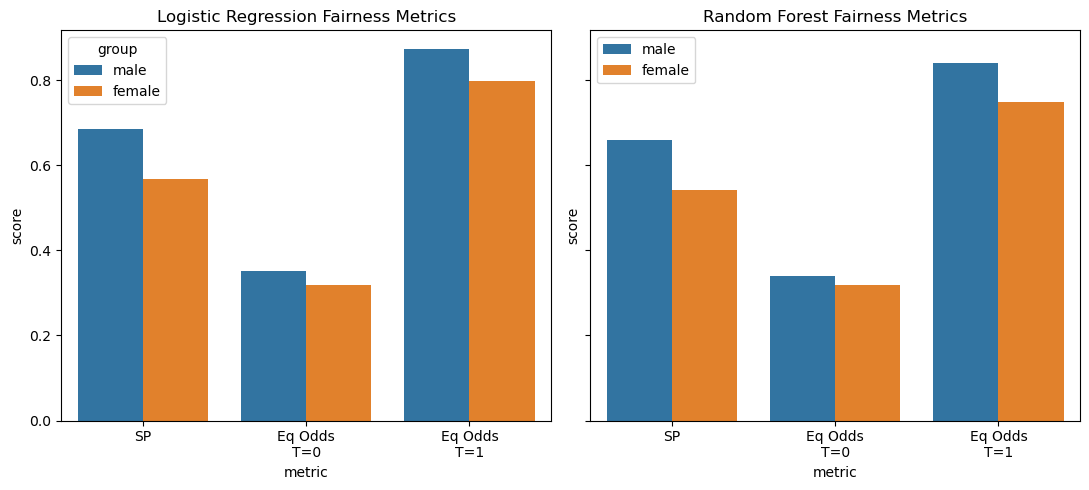

In [17]:
def new_accuracy(prob, thr_1, thr_2):    
    new_pred = []
    for i, y in list(enumerate(prob)):
        if not X_test['SEX_2'].iloc[i]:
            if y >= thr_1:
                new_pred.append(1)
            else:
                new_pred.append(0)
        else: 
            if y >= thr_2:
                new_pred.append(1)
            else:
                new_pred.append(0)
    new_y_pred = pd.DataFrame()
    new_y_pred['group_test'] = group_test
    new_y_pred['y_test'] = y_test
    new_y_pred['pred'] = new_pred

    stp_1 = np.mean(new_y_pred['pred'].where(new_y_pred['group_test'] == 1))
    stp_2 = np.mean(new_y_pred['pred'].where(new_y_pred['group_test'] == 2))
    eq_odds_T1_1 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 1).where(new_y_pred['group_test'] == 1))
    eq_odds_T1_2 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 1).where(new_y_pred['group_test'] == 2))
    eq_odds_T0_1 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 0).where(new_y_pred['group_test'] == 1))
    eq_odds_T0_2 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 0).where(new_y_pred['group_test'] == 2))
    
    scores = [(stp_1,stp_2), 
           (eq_odds_T0_1,eq_odds_T0_2), 
           (eq_odds_T1_1,eq_odds_T1_2)]
    names = ["stat_parity",
                "eq_odds_t0",
                "eq_odds_t1"]
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        g1,g2 = scores[i]
        new_metrics = {"score":[g1, g2], "metric" : [names[i], names[i]], "group":["male", "female"]}
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)
    
    return accuracy_score(y_test, new_pred), df_fair_metrics

new_log_accuracy, new_log_fairness = new_accuracy(log_y_prob, log_thr_group1, log_thr_group2)
new_forest_accuracy, new_forest_fairness = new_accuracy(forest_y_prob, forest_thr_group1, forest_thr_group2)

print(new_log_accuracy, new_forest_accuracy)
print(new_log_fairness)
print()
print(new_forest_fairness)
plot_fairness(new_log_fairness, new_forest_fairness)
plot_fairness(log_fairness, forest_fairness)

0.7448747791457497


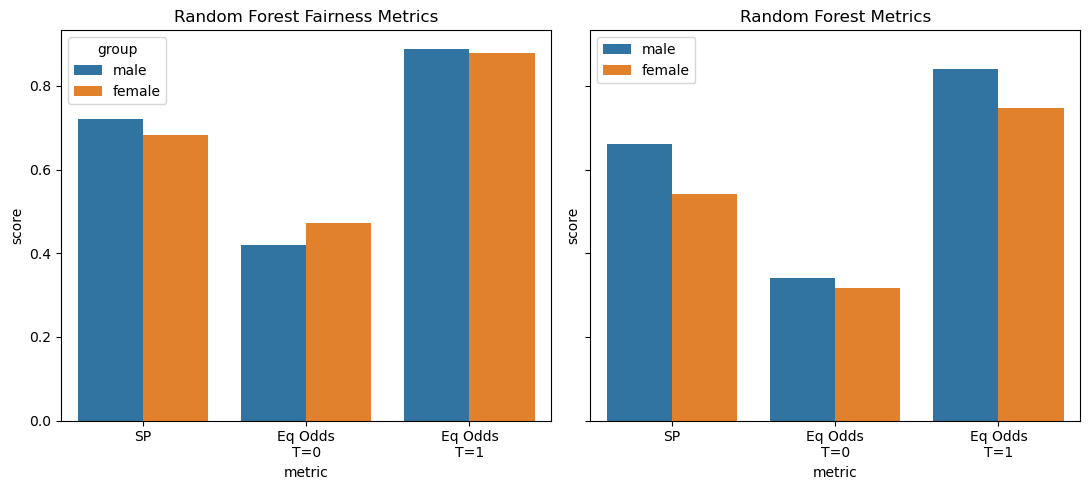

In [18]:
new_new_forest_accuracy, new_new_forest_fairness = new_accuracy(forest_y_prob, log_thr_group1, log_thr_group2)
print(new_new_forest_accuracy)

_, ax = plt.subplots(1,2, figsize=(11,5), sharey=True)

sns.barplot(data = new_new_forest_fairness,
                x = 'metric',
                y = 'score',
                hue = 'group',
                ax=ax[0]
                )

sns.barplot(data = forest_fairness,
                x = 'metric',
                y = 'score',
                hue = 'group',
                ax=ax[1]
                )


plt.legend()
ax[0].set_title("Random Forest Fairness Metrics")
ax[1].set_title("Random Forest Metrics")

ax[0].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])
ax[1].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])

plt.tight_layout()

plt.show()
